In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn import metrics
from sklearn import model_selection
import warnings, gc
warnings.filterwarnings("ignore")
import os

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide_310/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-pre

In [2]:
df_clinic = []
tmp = pd.read_csv("train_clinical_data.csv")
train_clinical = pd.read_csv("train_clinical_data.csv")
tmp["CSF"] = 1
df_clinic.append(tmp)
tmp = pd.read_csv("supplemental_clinical_data.csv")
tmp["CSF"] = 0
df_clinic.append(tmp)
df_clinic = pd.concat(df_clinic, axis=0).reset_index(drop=True)
df_clinic = df_clinic.rename(columns={"upd23b_clinical_state_on_medication": "medication"})

In [3]:
df_clinic

visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0         55_0          55            0     10.0      6.0     15.0      NaN   
1         55_3          55            3     10.0      7.0     25.0      NaN   
2         55_6          55            6      8.0     10.0     34.0      NaN   
3         55_9          55            9      8.0      9.0     30.0      0.0   
4        55_12          55           12     10.0     10.0     41.0      0.0   
...        ...         ...          ...      ...      ...      ...      ...   
4833   65382_0       65382            0      NaN      NaN      0.0      NaN   
4834   65405_0       65405            0      5.0     16.0     31.0      0.0   
4835   65405_5       65405            5      NaN      NaN     57.0      NaN   
4836   65530_0       65530            0     10.0      6.0     24.0      0.0   
4837  65530_36       65530           36      8.0      4.0     15.0      4.0   

     medication  CSF  
0           NaN    1  
1           NaN    1  
2           NaN    1  
3            On    1  
4            On    1  
...         ...  ...  
4833        NaN    0  
4834        NaN    0  
4835        NaN    0  
4836        NaN    0  
4837         On    0  

[4838 rows x 9 columns]

In [4]:
df_clinic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   visit_id     4838 non-null   object 
 1   patient_id   4838 non-null   int64  
 2   visit_month  4838 non-null   int64  
 3   updrs_1      4624 non-null   float64
 4   updrs_2      4622 non-null   float64
 5   updrs_3      4808 non-null   float64
 6   updrs_4      2872 non-null   float64
 7   medication   2410 non-null   object 
 8   CSF          4838 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 340.3+ KB


In [5]:
df_clinic.isna().sum()

visit_id          0
patient_id        0
visit_month       0
updrs_1         214
updrs_2         216
updrs_3          30
updrs_4        1966
medication     2428
CSF               0
dtype: int64

In [6]:
df_clinic.nunique()

visit_id       4838
patient_id     1019
visit_month      18
updrs_1          32
updrs_2          37
updrs_3          75
updrs_4          19
medication        2
CSF               2
dtype: int64

In [7]:
df_clinic.groupby("patient_id").size().describe()

count    1019.000000
mean        4.747792
std         4.050538
min         1.000000
25%         2.000000
50%         2.000000
75%         6.000000
max        17.000000
dtype: float64

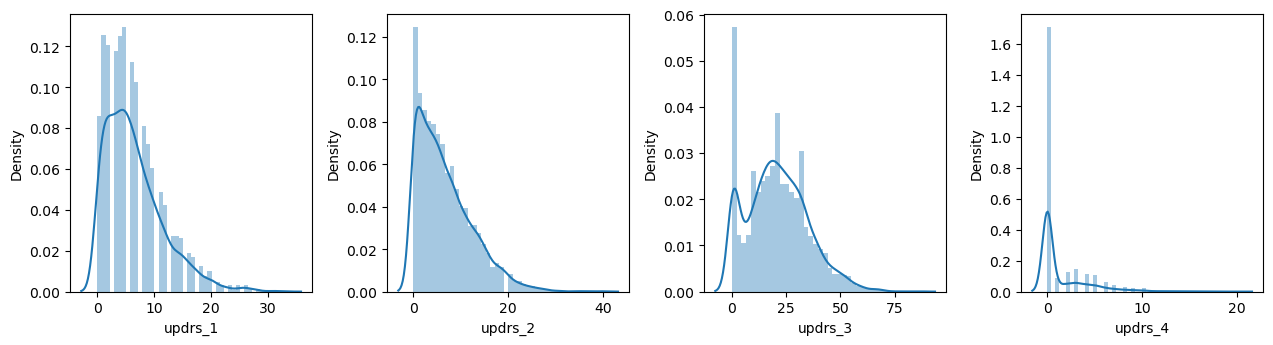

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,30))
features= ['updrs_1','updrs_2','updrs_3','updrs_4']

for i in range(len(features)):
    fig.add_subplot(9, 5, i+1)
    sns.distplot(df_clinic[features[i]])
plt.tight_layout()
plt.show()

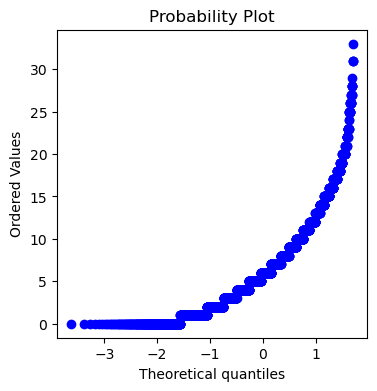

In [9]:
from scipy import stats
fig, (ax) = plt.subplots(figsize = (4,4))
res = stats.probplot(df_clinic['updrs_1'],dist='norm', plot=ax)

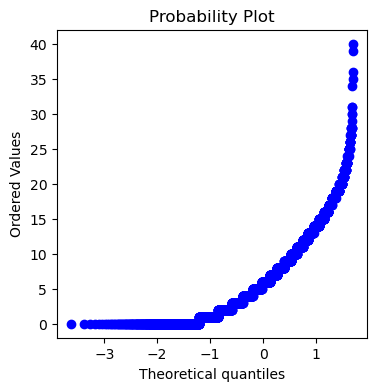

In [10]:
from scipy import stats
fig, (ax) = plt.subplots(figsize = (4,4))
res = stats.probplot(df_clinic['updrs_2'],dist='norm', plot=ax)

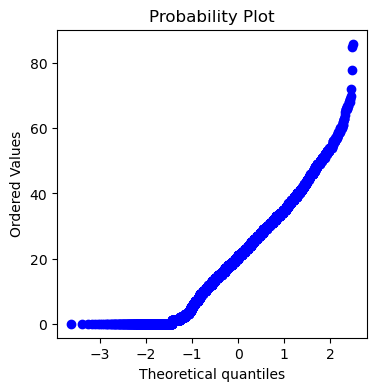

In [11]:
from scipy import stats
fig, (ax) = plt.subplots(figsize = (4,4))
res = stats.probplot(df_clinic['updrs_3'],dist='norm', plot=ax)

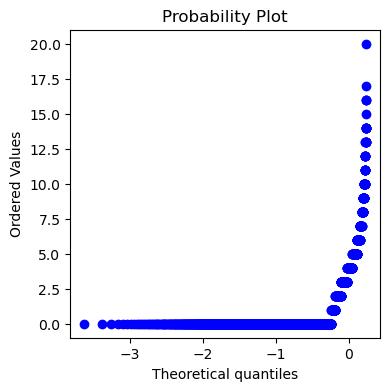

In [12]:
from scipy import stats
fig, (ax) = plt.subplots(figsize = (4,4))
res = stats.probplot(df_clinic['updrs_4'],dist='norm', plot=ax)

**The q-q plots suggest that updrs_1, updrs_2 and updrs_4 have huge deviation from normal distribution wheras updrs_3 is not much deviated and correction is much easier.**

In [13]:
skewness_1 = df_clinic['updrs_1'].skew()
print(f'Skewness for updrs_1 = {skewness_1}')

skewness_2 = df_clinic['updrs_2'].skew()
print(f'Skewness for updrs_2 = {skewness_2}')

skewness_3 = df_clinic['updrs_3'].skew()
print(f'Skewness for updrs_3 = {skewness_3}')

skewness_4 = df_clinic['updrs_4'].skew()
print(f'Skewness for updrs_4 = {skewness_4}')

Skewness for updrs_1 = 1.19772289416051
Skewness for updrs_2 = 1.1140658886401753
Skewness for updrs_3 = 0.4637341727165147
Skewness for updrs_4 = 2.293804042886257


All the above visualizations suggest that
Inferences:
* All targets are not normal distribution
* updrs_4 has zeros as much as about 40% (It seems to be good to impute with zeros)
* all the plots are right/positive skewed

   updrs_1  updrs_2  updrs_3  updrs_4
0     10.0      6.0     15.0      NaN
1     10.0      7.0     25.0      NaN
2      8.0     10.0     34.0      NaN
3      8.0      9.0     30.0      0.0
4     10.0     10.0     41.0      0.0


<AxesSubplot:>

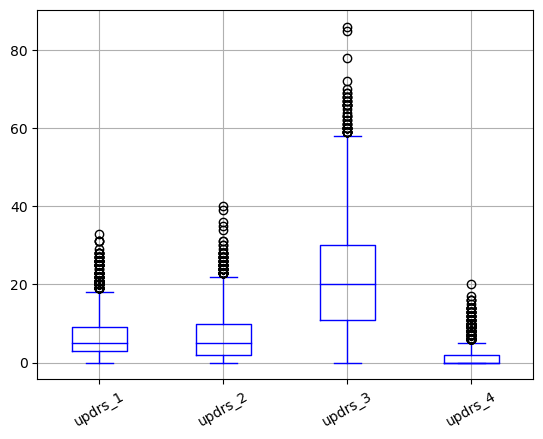

In [14]:
import pandas as pd
import numpy as np
dataframe = pd.DataFrame(df_clinic, columns=['updrs_1','updrs_2','updrs_3','updrs_4'])
print(dataframe.head())
dataframe.boxplot(grid='false', color='blue',fontsize=10, rot=30 )

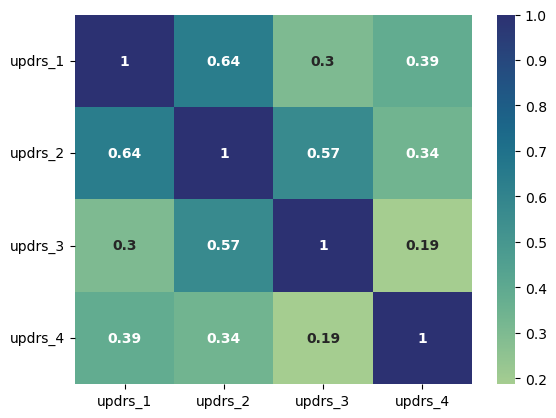

In [15]:
sns.heatmap(df_clinic.filter(regex="updrs_*").dropna().corr(), cmap="crest", annot=True, annot_kws={"fontweight": "bold"})
plt.yticks(rotation=0)
plt.show()

**updrs_2 has high correlation with updrs_1 & updrs_3 (about 0.6)**

In [16]:
df_eda = df_clinic.groupby("patient_id")["visit_month"].max()

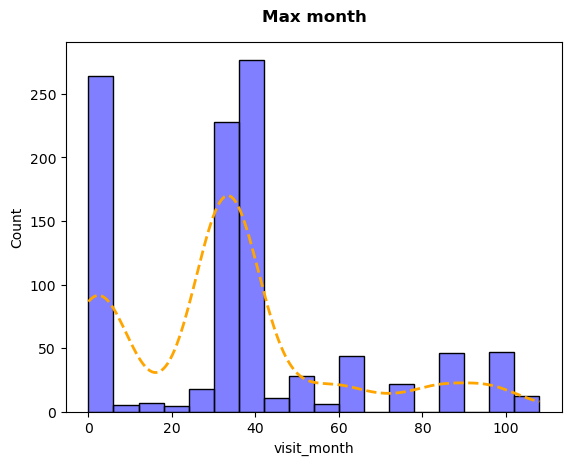

In [17]:
ax = sns.histplot(df_eda, kde=True, color="blue", line_kws={'linewidth': 2, 'linestyle': '--'})
ax.lines[0].set_color('orange')
plt.title(f"Max month", fontweight="bold", pad=15)
plt.show()

**Short-term(0-5) and mid-term(30-36) bins show high medical examination count**

In [18]:
df_eda = df_clinic.groupby("visit_month", as_index=False).mean().dropna()
df_eda

visit_month    patient_id   updrs_1   updrs_2    updrs_3   updrs_4  \
0             0  32284.550540  5.725108  5.734848  18.312684  1.186517   
1             3  33128.895652  5.513043  6.634783  20.482456  0.142857   
3             6  33402.718182  5.938636  6.670455  22.143836  1.427419   
4             9  33544.020202  6.080808  7.204082  20.474747  0.488372   
5            12  32921.261506  5.736402  5.765690  19.726891  0.953668   
6            18  33228.782369  6.344353  6.776860  21.576177  0.938697   
7            24  32608.661327  6.304348  6.153318  19.889145  1.290850   
8            30  33159.085859  6.739899  7.043038  22.650633  1.260736   
9            36  31899.322314  6.981405  6.764463  20.160083  1.042857   
10           42  32411.733766  8.339869  8.372549  22.720779  1.868613   
11           48  32227.581633  7.581633  7.112245  19.378238  1.970588   
12           54  32156.790909  8.600000  9.863636  26.311927  2.051020   
13           60  31770.084337  7.265060  6.500000  19.807229  2.218182   
14           72  33528.666667  8.365591  8.817204  26.450549  2.289157   
15           84  32186.740000  7.730000  8.230000  22.589474  2.938462   
16           96  30539.310345  7.706897  7.775862  21.267857  4.233333   
17          108  32552.833333  9.416667  8.166667  25.250000  2.571429   

         CSF  
0   0.243376  
1   1.000000  
3   0.436364  
4   1.000000  
5   0.508368  
6   0.515152  
7   0.556064  
8   0.436869  
9   0.466942  
10  1.000000  
11  1.000000  
12  1.000000  
13  1.000000  
14  1.000000  
15  1.000000  
16  1.000000  
17  1.000000

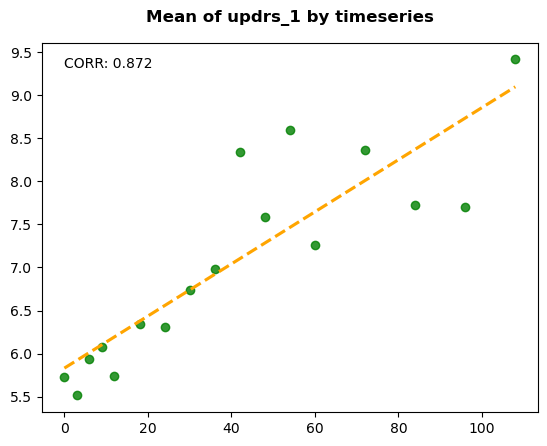

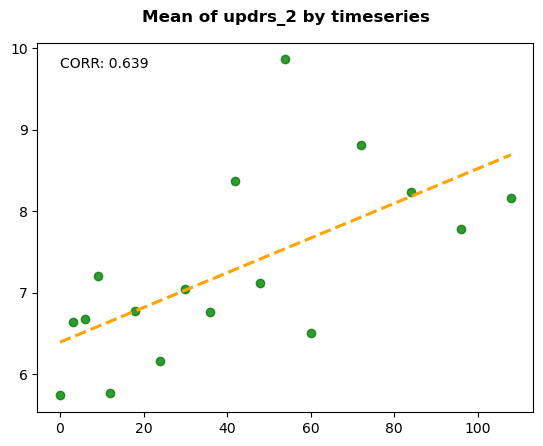

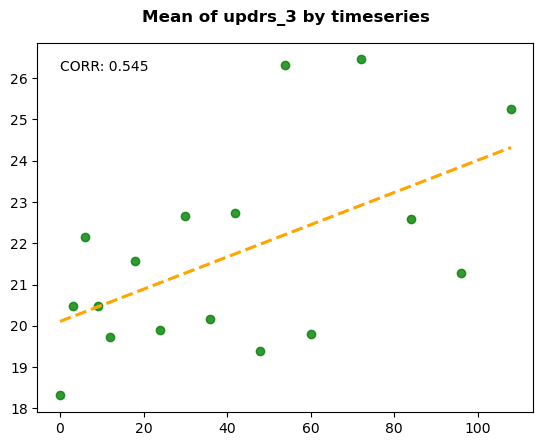

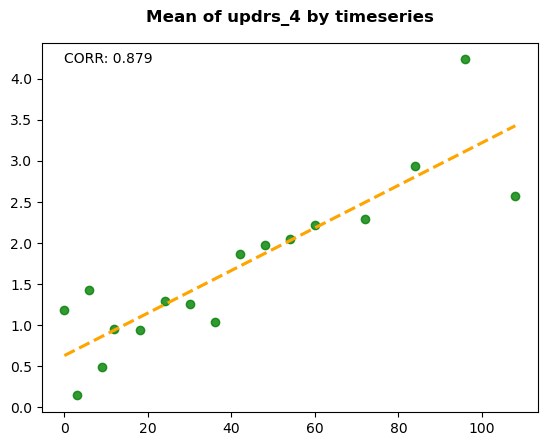

In [19]:
for i in range(4):    
    sns.regplot(x=df_eda["visit_month"].values, y=df_eda[f"updrs_{i+1}"].values, color="green", ci=None, line_kws={"color": "orange", "linestyle": "--"})
    plt.title(f"Mean of updrs_{i+1} by timeseries", fontweight="bold", pad=15)
    plt.text(0, df_eda[f"updrs_{i+1}"].values.max() * 0.99, f'CORR: {round(df_eda.corr().loc["visit_month", f"updrs_{i+1}"], 3)}')
    plt.show()

**This clearly shows that as time progresses severity of parkinson increases which is also reflected by updrs values**

In [20]:
df_eda = df_clinic.dropna()

Two groups are difference ! -> pvalue: 0.00248


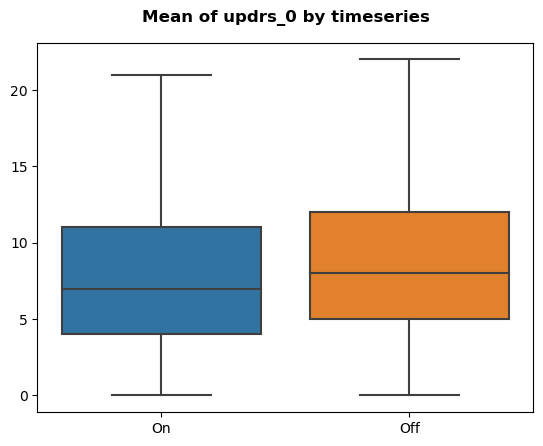

Two groups are difference ! -> pvalue: 0.0


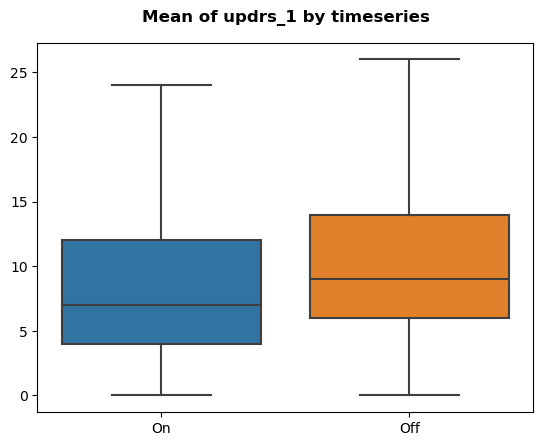

Two groups are difference ! -> pvalue: 0.0


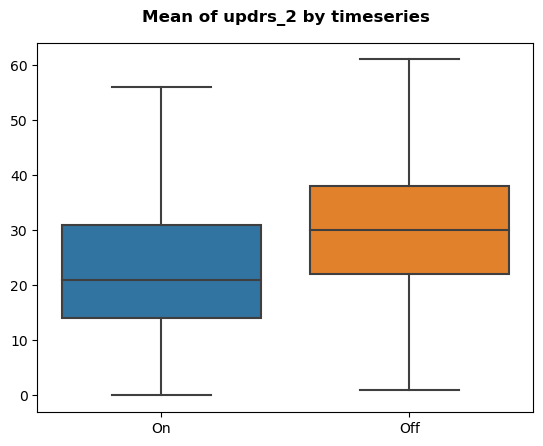

Two groups are difference ! -> pvalue: 0.00078


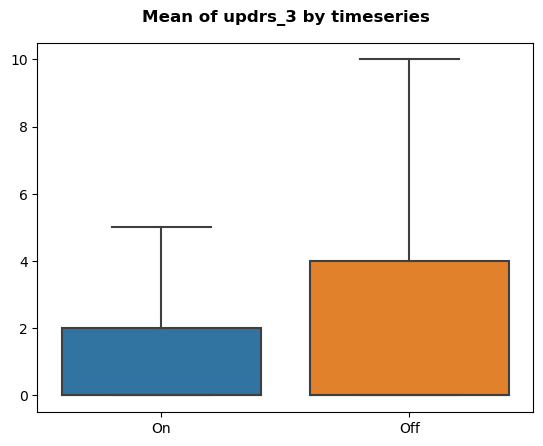

In [21]:
from scipy.stats import f_oneway

for i in range(4):    
    sns.boxplot(x=df_eda["medication"].values, y=df_eda[f"updrs_{i+1}"].values, showfliers=False)
    plt.title(f"Mean of updrs_{i} by timeseries", fontweight="bold", pad=15)
    _, pvalue = f_oneway(df_eda.loc[df_eda["medication"] == "On", f"updrs_{i+1}"].values, df_eda.loc[df_eda["medication"] == "Off", f"updrs_{i+1}"].values)
    if pvalue < 0.05:
        print("Two groups are difference ! -> pvalue:", round(pvalue, 5))
    plt.show()

**Observation -**
* updrs Median values of patients on medication is significantly less than that of patients not on medication.

**Inference -**
* Medication slows progress of parkinson's disease.
* Medication must also be considered as factor while determining updrs scores.

**SUMMARY OF CLINICAL DATA** - 

* All targets are not normal distribution
* updrs_4 has zeros as much as about 40% (It seems to be good to impute with zeros)
* Short-term(0-5) and mid-term(30-36) bins show high medical examination count
* Medication is effective on reducing the updrs level
* Provided original data and additional data statistically has no difference mean in all ndprs values
* Therefore, We can use additional data as same way as original data without anxiety which be able to have bias

In [22]:
train_proteins = pd.read_csv("train_proteins.csv")
train_proteins

visit_id  visit_month  patient_id UniProt       NPX
0            55_0            0          55  O00391   11254.3
1            55_0            0          55  O00533  732430.0
2            55_0            0          55  O00584   39585.8
3            55_0            0          55  O14498   41526.9
4            55_0            0          55  O14773   31238.0
...           ...          ...         ...     ...       ...
232736  58648_108          108       58648  Q9UBX5   27387.8
232737  58648_108          108       58648  Q9UHG2  369437.0
232738  58648_108          108       58648  Q9UKV8  105830.0
232739  58648_108          108       58648  Q9Y646   21257.6
232740  58648_108          108       58648  Q9Y6R7   17953.1

[232741 rows x 5 columns]

In [23]:
train_peptides = pd.read_csv("train_peptides.csv")
train_peptides

visit_id  visit_month  patient_id UniProt  \
0            55_0            0          55  O00391   
1            55_0            0          55  O00533   
2            55_0            0          55  O00533   
3            55_0            0          55  O00533   
4            55_0            0          55  O00533   
...           ...          ...         ...     ...   
981829  58648_108          108       58648  Q9UHG2   
981830  58648_108          108       58648  Q9UKV8   
981831  58648_108          108       58648  Q9Y646   
981832  58648_108          108       58648  Q9Y6R7   
981833  58648_108          108       58648  Q9Y6R7   

                                       Peptide  PeptideAbundance  
0                                NEQEQPLGQWHLS          11254.30  
1                                  GNPEPTFSWTK         102060.00  
2                              IEIPSSVQQVPTIIK         174185.00  
3       KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK          27278.90  
4                                 SMEQNGPGLEYR          30838.70  
...                                        ...               ...  
981829                         ILAGSADSEGVAAPR         202820.00  
981830                           SGNIPAGTTVDTK         105830.00  
981831                             LALLVDTVGPR          21257.60  
981832        AGC(UniMod_4)VAESTAVC(UniMod_4)R           5127.26  
981833                          GATTSPGVYELSSR          12825.90  

[981834 rows x 6 columns]

In [24]:
all(train_proteins[['visit_id', 'UniProt']].value_counts() == 1)

True

Hence we can say that all r unique

In [25]:
df_p = train_peptides.merge(train_proteins[['visit_id', 'UniProt', 'NPX']], on=['visit_id','UniProt'], how='left')
df_p.head()

visit_id  visit_month  patient_id UniProt  \
0     55_0            0          55  O00391   
1     55_0            0          55  O00533   
2     55_0            0          55  O00533   
3     55_0            0          55  O00533   
4     55_0            0          55  O00533   

                                  Peptide  PeptideAbundance       NPX  
0                           NEQEQPLGQWHLS           11254.3   11254.3  
1                             GNPEPTFSWTK          102060.0  732430.0  
2                         IEIPSSVQQVPTIIK          174185.0  732430.0  
3  KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK           27278.9  732430.0  
4                            SMEQNGPGLEYR           30838.7  732430.0

It makes sense to transfer proteins' NPX value to peptide data on merge, since each protein could consist of multiple peptides.

In [26]:
train_scd = pd.read_csv("supplemental_clinical_data.csv")
train_cd = pd.read_csv("train_clinical_data.csv")

train_scd['visit_id'] = train_scd['patient_id'].astype(str) + "_"+ train_scd['visit_month'].astype(str)

#Here we combine both main and supplemental clinical data into a single dataframe
df_cd = pd.concat([train_cd, train_scd], ignore_index=True)
display(df_cd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             4838 non-null   object 
 1   patient_id                           4838 non-null   int64  
 2   visit_month                          4838 non-null   int64  
 3   updrs_1                              4624 non-null   float64
 4   updrs_2                              4622 non-null   float64
 5   updrs_3                              4808 non-null   float64
 6   updrs_4                              2872 non-null   float64
 7   upd23b_clinical_state_on_medication  2410 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 302.5+ KB


None

In [27]:
print(f'Unique Clinical Data patient #: {train_cd["patient_id"].nunique()}')
print("----------------------------------------------------------")
print(f'Null Values Found in Clinical Data:')
for col in train_cd.columns:
    print(f'Null values found in {col}: {train_cd[col].isna().sum()}')
print('')

Unique Clinical Data patient #: 248
----------------------------------------------------------
Null Values Found in Clinical Data:
Null values found in visit_id: 0
Null values found in patient_id: 0
Null values found in visit_month: 0
Null values found in updrs_1: 1
Null values found in updrs_2: 2
Null values found in updrs_3: 25
Null values found in updrs_4: 1038
Null values found in upd23b_clinical_state_on_medication: 1327



Since Null values in updrs_3, updrs_2, updrs_1 are too less; we can impute using linear interpolation

In [28]:
train_cd.updrs_1 = train_cd.updrs_3.interpolate(method='linear', axis=0)
train_cd.updrs_2 = train_cd.updrs_3.interpolate(method='linear', axis=0)
train_cd.updrs_3 = train_cd.updrs_3.interpolate(method='linear', axis=0)
train_cd['updrs_4'] = train_cd['updrs_4'].fillna(0)

In [29]:
print(f'Unique Clinical Data patient #: {train_cd["patient_id"].nunique()}')
print("----------------------------------------------------------")
print(f'Null Values Found in Clinical Data:')
for col in train_cd.columns:
    print(f'Null values found in {col}: {train_cd[col].isna().sum()}')
print('')

Unique Clinical Data patient #: 248
----------------------------------------------------------
Null Values Found in Clinical Data:
Null values found in visit_id: 0
Null values found in patient_id: 0
Null values found in visit_month: 0
Null values found in updrs_1: 0
Null values found in updrs_2: 0
Null values found in updrs_3: 0
Null values found in updrs_4: 0
Null values found in upd23b_clinical_state_on_medication: 1327



In [30]:
df_cd.melt(id_vars=['visit_id', 'patient_id', 'visit_month', 'upd23b_clinical_state_on_medication'], 
                   var_name='updrs', value_name='rating')

visit_id  patient_id  visit_month upd23b_clinical_state_on_medication  \
0          55_0          55            0                                 NaN   
1          55_3          55            3                                 NaN   
2          55_6          55            6                                 NaN   
3          55_9          55            9                                  On   
4         55_12          55           12                                  On   
...         ...         ...          ...                                 ...   
19347   65382_0       65382            0                                 NaN   
19348   65405_0       65405            0                                 NaN   
19349   65405_5       65405            5                                 NaN   
19350   65530_0       65530            0                                 NaN   
19351  65530_36       65530           36                                  On   

         updrs  rating  
0      updrs_1    10.0  
1      updrs_1    10.0  
2      updrs_1     8.0  
3      updrs_1     8.0  
4      updrs_1    10.0  
...        ...     ...  
19347  updrs_4     NaN  
19348  updrs_4     0.0  
19349  updrs_4     NaN  
19350  updrs_4     0.0  
19351  updrs_4     4.0  

[19352 rows x 6 columns]

In [31]:
df_all = df_p.merge(df_cd[['visit_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication']], on=['visit_id'], how='left')
df_all.info()
df_all

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981834 entries, 0 to 981833
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   visit_id                             981834 non-null  object 
 1   visit_month                          981834 non-null  int64  
 2   patient_id                           981834 non-null  int64  
 3   UniProt                              981834 non-null  object 
 4   Peptide                              981834 non-null  object 
 5   PeptideAbundance                     981834 non-null  float64
 6   NPX                                  981834 non-null  float64
 7   updrs_1                              941744 non-null  float64
 8   updrs_2                              941744 non-null  float64
 9   updrs_3                              932624 non-null  float64
 10  updrs_4                              495530 non-null  float64
 11  upd23b_clinic

visit_id  visit_month  patient_id UniProt  \
0            55_0            0          55  O00391   
1            55_0            0          55  O00533   
2            55_0            0          55  O00533   
3            55_0            0          55  O00533   
4            55_0            0          55  O00533   
...           ...          ...         ...     ...   
981829  58648_108          108       58648  Q9UHG2   
981830  58648_108          108       58648  Q9UKV8   
981831  58648_108          108       58648  Q9Y646   
981832  58648_108          108       58648  Q9Y6R7   
981833  58648_108          108       58648  Q9Y6R7   

                                       Peptide  PeptideAbundance       NPX  \
0                                NEQEQPLGQWHLS          11254.30   11254.3   
1                                  GNPEPTFSWTK         102060.00  732430.0   
2                              IEIPSSVQQVPTIIK         174185.00  732430.0   
3       KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK          27278.90  732430.0   
4                                 SMEQNGPGLEYR          30838.70  732430.0   
...                                        ...               ...       ...   
981829                         ILAGSADSEGVAAPR         202820.00  369437.0   
981830                           SGNIPAGTTVDTK         105830.00  105830.0   
981831                             LALLVDTVGPR          21257.60   21257.6   
981832        AGC(UniMod_4)VAESTAVC(UniMod_4)R           5127.26   17953.1   
981833                          GATTSPGVYELSSR          12825.90   17953.1   

        updrs_1  updrs_2  updrs_3  updrs_4 upd23b_clinical_state_on_medication  
0          10.0      6.0     15.0      NaN                                 NaN  
1          10.0      6.0     15.0      NaN                                 NaN  
2          10.0      6.0     15.0      NaN                                 NaN  
3          10.0      6.0     15.0      NaN                                 NaN  
4          10.0      6.0     15.0      NaN                                 NaN  
...         ...      ...      ...      ...                                 ...  
981829      6.0      0.0      0.0      NaN                                 NaN  
981830      6.0      0.0      0.0      NaN                                 NaN  
981831      6.0      0.0      0.0      NaN                                 NaN  
981832      6.0      0.0      0.0      NaN                                 NaN  
981833      6.0      0.0      0.0      NaN                                 NaN  

[981834 rows x 12 columns]

In [32]:
print("\n.... Total patients: ", train_peptides.patient_id.nunique())

print("\n.... Total number of visits:", train_proteins['visit_id'].nunique())

print("\n.... Total proteins: ", train_proteins.UniProt.nunique())

print("\n.... Total peptides: ", train_peptides.Peptide.nunique())

print("\n.... Months counts:")
print(train_proteins.visit_month.value_counts())


.... Total patients:  248

.... Total number of visits: 1113

.... Total proteins:  227

.... Total peptides:  968

.... Months counts:
0      40587
12     37467
24     36225
36     31156
48     28838
6      25991
60     17572
84      6288
72      4407
18      1657
108      855
3        641
96       423
54       418
30       216
Name: visit_month, dtype: int64


**Inferences** -
* There are 248 patients in the dataset.
* There are 1,113 visit_id, which means each patient visited around 4.48 times on average. This means, on average, each patient has 4~5 records.
* There are often several peptides per protein. You should merge peptides dataset to proteins.
* There are 227 unique UniProt ID, while there are 968 types of peptide.
* Data for some patients goes as far as 108 months or 9 years

<AxesSubplot:>

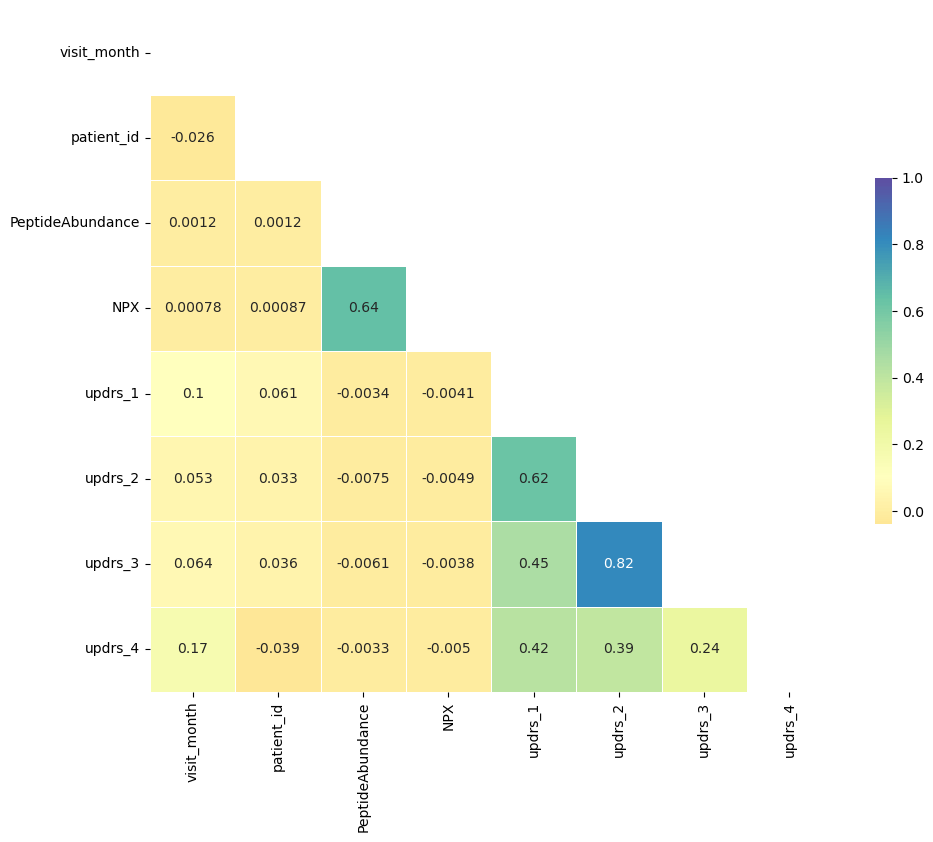

In [33]:
corr = df_all.corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap='Spectral', vmax=1, center=0.1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [34]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_all, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
print(f'Unique Clinical Data patient #: {df_all["patient_id"].nunique()}')
print("----------------------------------------------------------")
print(f'Null Values Found in Clinical Data:')
for col in df_all.columns:
    print(f'Null values found in {col}: {df_all[col].isna().sum()}')
print('')

Unique Clinical Data patient #: 248
----------------------------------------------------------
Null Values Found in Clinical Data:
Null values found in visit_id: 0
Null values found in visit_month: 0
Null values found in patient_id: 0
Null values found in UniProt: 0
Null values found in Peptide: 0
Null values found in PeptideAbundance: 0
Null values found in NPX: 0
Null values found in updrs_1: 40090
Null values found in updrs_2: 40090
Null values found in updrs_3: 49210
Null values found in updrs_4: 486304
Null values found in upd23b_clinical_state_on_medication: 590109



In [36]:
import scipy.stats as st
import pandas as pd
import plotly.express as px

In [37]:
df_clinic

visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0         55_0          55            0     10.0      6.0     15.0      NaN   
1         55_3          55            3     10.0      7.0     25.0      NaN   
2         55_6          55            6      8.0     10.0     34.0      NaN   
3         55_9          55            9      8.0      9.0     30.0      0.0   
4        55_12          55           12     10.0     10.0     41.0      0.0   
...        ...         ...          ...      ...      ...      ...      ...   
4833   65382_0       65382            0      NaN      NaN      0.0      NaN   
4834   65405_0       65405            0      5.0     16.0     31.0      0.0   
4835   65405_5       65405            5      NaN      NaN     57.0      NaN   
4836   65530_0       65530            0     10.0      6.0     24.0      0.0   
4837  65530_36       65530           36      8.0      4.0     15.0      4.0   

     medication  CSF  
0           NaN    1  
1           NaN    1  
2           NaN    1  
3            On    1  
4            On    1  
...         ...  ...  
4833        NaN    0  
4834        NaN    0  
4835        NaN    0  
4836        NaN    0  
4837         On    0  

[4838 rows x 9 columns]

In [38]:
df_clinic=df_clinic.dropna()

In [39]:
print(df_clinic[['updrs_1','updrs_2','updrs_3']])

      updrs_1  updrs_2  updrs_3
3         8.0      9.0     30.0
4        10.0     10.0     41.0
5         7.0     13.0     38.0
6        16.0      9.0     49.0
7        14.0     13.0     49.0
...       ...      ...      ...
4823     26.0     20.0     31.0
4828      4.0     14.0     13.0
4829      2.0     13.0     14.0
4830      4.0     16.0     13.0
4837      8.0      4.0     15.0

[2076 rows x 3 columns]


In [40]:
x = df_clinic['updrs_1']
y = df_clinic['updrs_2']
z = df_clinic['updrs_3']
print("the pearson correlation between updrs_1 and updrs_2 values:")
st.pearsonr(x,y)[0]


the pearson correlation between updrs_1 and updrs_2 values:


0.6123822155904516

In [41]:
print("the pearson correlation between updrs_2 and updrs_3 values:")
st.pearsonr(y,z)[0]


the pearson correlation between updrs_2 and updrs_3 values:


0.5302471946187703

In [42]:
print("the pearson correlation between updrs_1 and updrs_3 values:")
st.pearsonr(x,z)[0]

the pearson correlation between updrs_1 and updrs_3 values:


0.2546524247892686

inference:
as we already know that updrs_2 is nearly strongly corelated with updrs_1 and 3
but correlation of updrs_1 and updrs_3 is weak but positive 

In [43]:
train_proteins

visit_id  visit_month  patient_id UniProt       NPX
0            55_0            0          55  O00391   11254.3
1            55_0            0          55  O00533  732430.0
2            55_0            0          55  O00584   39585.8
3            55_0            0          55  O14498   41526.9
4            55_0            0          55  O14773   31238.0
...           ...          ...         ...     ...       ...
232736  58648_108          108       58648  Q9UBX5   27387.8
232737  58648_108          108       58648  Q9UHG2  369437.0
232738  58648_108          108       58648  Q9UKV8  105830.0
232739  58648_108          108       58648  Q9Y646   21257.6
232740  58648_108          108       58648  Q9Y6R7   17953.1

[232741 rows x 5 columns]

In [44]:
print(train_proteins[['UniProt','NPX']])

       UniProt       NPX
0       O00391   11254.3
1       O00533  732430.0
2       O00584   39585.8
3       O14498   41526.9
4       O14773   31238.0
...        ...       ...
232736  Q9UBX5   27387.8
232737  Q9UHG2  369437.0
232738  Q9UKV8  105830.0
232739  Q9Y646   21257.6
232740  Q9Y6R7   17953.1

[232741 rows x 2 columns]


In [45]:
x = train_proteins['UniProt']
y = train_proteins['NPX']
print("the spearman correlation between UniProt and NPX values:")
st.spearmanr(x,y).correlation

the spearman correlation between UniProt and NPX values:


-0.28635903235123744

In [46]:
train_peptides

visit_id  visit_month  patient_id UniProt  \
0            55_0            0          55  O00391   
1            55_0            0          55  O00533   
2            55_0            0          55  O00533   
3            55_0            0          55  O00533   
4            55_0            0          55  O00533   
...           ...          ...         ...     ...   
981829  58648_108          108       58648  Q9UHG2   
981830  58648_108          108       58648  Q9UKV8   
981831  58648_108          108       58648  Q9Y646   
981832  58648_108          108       58648  Q9Y6R7   
981833  58648_108          108       58648  Q9Y6R7   

                                       Peptide  PeptideAbundance  
0                                NEQEQPLGQWHLS          11254.30  
1                                  GNPEPTFSWTK         102060.00  
2                              IEIPSSVQQVPTIIK         174185.00  
3       KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK          27278.90  
4                                 SMEQNGPGLEYR          30838.70  
...                                        ...               ...  
981829                         ILAGSADSEGVAAPR         202820.00  
981830                           SGNIPAGTTVDTK         105830.00  
981831                             LALLVDTVGPR          21257.60  
981832        AGC(UniMod_4)VAESTAVC(UniMod_4)R           5127.26  
981833                          GATTSPGVYELSSR          12825.90  

[981834 rows x 6 columns]

In [47]:
print(train_peptides[['UniProt','Peptide','PeptideAbundance']])

       UniProt                                 Peptide  PeptideAbundance
0       O00391                           NEQEQPLGQWHLS          11254.30
1       O00533                             GNPEPTFSWTK         102060.00
2       O00533                         IEIPSSVQQVPTIIK         174185.00
3       O00533  KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK          27278.90
4       O00533                            SMEQNGPGLEYR          30838.70
...        ...                                     ...               ...
981829  Q9UHG2                         ILAGSADSEGVAAPR         202820.00
981830  Q9UKV8                           SGNIPAGTTVDTK         105830.00
981831  Q9Y646                             LALLVDTVGPR          21257.60
981832  Q9Y6R7        AGC(UniMod_4)VAESTAVC(UniMod_4)R           5127.26
981833  Q9Y6R7                          GATTSPGVYELSSR          12825.90

[981834 rows x 3 columns]


In [48]:
x = train_peptides['UniProt']
y = train_peptides['Peptide']
z = train_peptides['PeptideAbundance']
print("the spearman correlation between UniProt and PeptideAbundance values:")
st.spearmanr(x,z).correlation

the spearman correlation between UniProt and PeptideAbundance values:


-0.1598701337706343

In [49]:
print("the spearman correlation between Peptide and PeptideAbundance values:")
st.spearmanr(y,z).correlation

the spearman correlation between Peptide and PeptideAbundance values:


0.03179083517499906

In [50]:
def calculateB(x, y, n):

    sx = sum(x)
    sy = sum(y)
    sxsy = 0

    sx2 = 0
 
    for i in range(n):
        sxsy += x[i] * y[i]
        sx2 += x[i] * x[i]
    b = (n * sxsy - sx * sy)/(n * sx2 - sx * sx)
    return b
 

def leastRegLine(X,Y,n):
     
    # Finding b
    b = calculateB(X, Y, n)
    meanX = int(sum(X)/n)
    meanY = int(sum(Y)/n)

    a = meanY - b * meanX

    print("Regression line:")
    print("Y = ", '%.3f'%a, " + ", '%.3f'%b, "*X", sep="")
 

X = df_clinic['updrs_1'].values
Y = df_clinic['updrs_2'].values
Z = df_clinic['updrs_3'].values
n = len(X)
print('best fit line for updrs_1 vs updrs_2 :')
leastRegLine(X, Y, n)
print('best fit line for updrs_2 vs updrs_3 :')
leastRegLine(Y, Z, n)
print('best fit line for updrs_1 vs updrs_3 :')
leastRegLine(X, Z, n)

best fit line for updrs_1 vs updrs_2 :
Regression line:
Y = 2.806 + 0.649*X
best fit line for updrs_2 vs updrs_3 :
Regression line:
Y = 15.932 + 1.133*X
best fit line for updrs_1 vs updrs_3 :
Regression line:
Y = 20.383 + 0.577*X


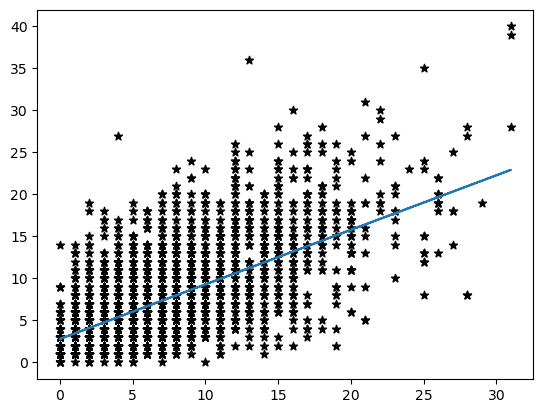

In [51]:
b = calculateB(X, Y, n)
meanX = int(sum(X)/n)
meanY = int(sum(Y)/n)
    
a = meanY - b * meanX

import matplotlib.pyplot as plt

X = df_clinic['updrs_1'].values
Y = df_clinic['updrs_2'].values

# Drawn a simple scatter plot for the data given
plt.scatter(X, Y, marker='*', color='k')

# Plotting the straight line by using the generated parameters
plt.plot(X, b*X+a)

plt.show()


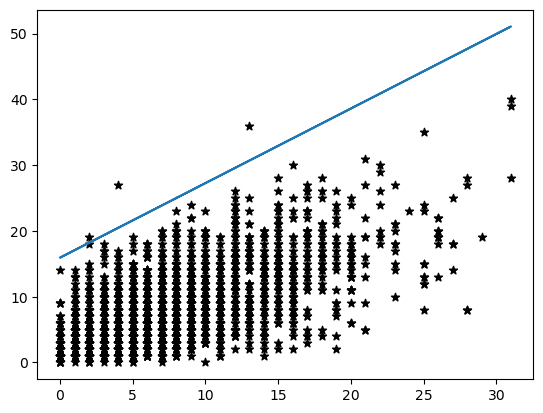

In [52]:
b = calculateB(Y, Z, n)
meanX = int(sum(Y)/n)
meanY = int(sum(Z)/n)
    
a = meanY - b * meanX

import matplotlib.pyplot as plt

X = df_clinic['updrs_1'].values
Y = df_clinic['updrs_2'].values

# Drawn a simple scatter plot for the data given
plt.scatter(X, Y, marker='*', color='k')

# Plotting the straight line by using the generated parameters
plt.plot(X, b*X+a)

plt.show()

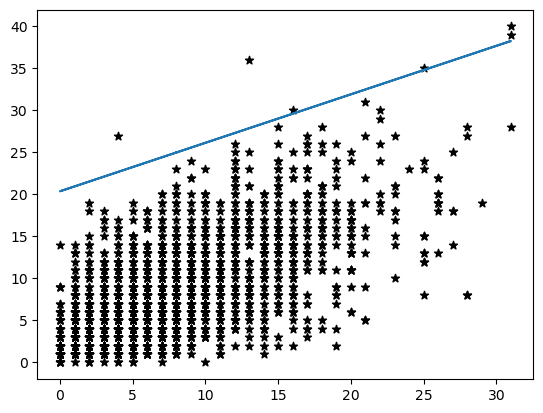

In [53]:
b = calculateB(X, Z, n)
meanX = int(sum(X)/n)
meanY = int(sum(Z)/n)
    
a = meanY - b * meanX

import matplotlib.pyplot as plt

X = df_clinic['updrs_1'].values
Y = df_clinic['updrs_2'].values

# Drawn a simple scatter plot for the data given
plt.scatter(X, Y, marker='*', color='k')

# Plotting the straight line by using the generated parameters
plt.plot(X, b*X+a)

plt.show()

In [54]:
df = pd.DataFrame({"A":X, 
                   "B":Y,
                   "C":Z})
df.cov()
  

A          B           C
A  31.134410  20.215184   17.969788
B  20.215184  35.000127   39.672358
C  17.969788  39.672358  159.937257

In [55]:
unique_visit_ids = train_proteins['visit_id'].unique()

# Create an empty DataFrame to hold the values of 'NPX' for each 'visit_id' and 'UniProt' combination
new_df = pd.DataFrame({'visit_id': unique_visit_ids})

# Loop over the unique values in the 'UniProt' column and add a column to the new DataFrame for each value
for uniprot in train_proteins['UniProt'].unique():
    uniprot_df = train_proteins[train_proteins['UniProt'] == uniprot][['visit_id', 'NPX']].rename(columns={'NPX': uniprot})
    new_df = pd.merge(new_df, uniprot_df, on='visit_id', how='left')

# For every visit_id (n visits) with proteins recorded, record the amount of each protein observed (assume there are d proteins total)
# X is n x d, where n=number of samples and d=number of features
new_df = new_df.fillna(0) # Fill the NaN values with 0 to account for the proteins that weren't recorded in a visit (preseumed to be 0)
X = new_df.sort_values(by=new_df.columns[0]) # Laastly we sort the values of X in ascending visit order

def parse_severity(value,moderate_min,moderate_max):
    severity = None
    if value<moderate_min: 
        severity = 0
    if value>=moderate_min and value<=moderate_max: 
        severity = 1
    if value>moderate_max: 
        severity = 2
    return severity

# For each visit_id (n visits) with proteins recorded, create a new categorical variable for UPDRSi severity
# y is n x x, where x is the number of divisions you want to have over your Parkinson's disease severity, 
# here x=3 so we can divide UPDRS severity into mild, moderate, and severe

# UPDRS1 severity (range 0-52) (mild = 0 (<11), moderate = 1 (11-21), severe = 2 (>21))
y1 = pd.DataFrame({'visit_id': df_clinic['visit_id'], 'UPDRS1_severity': df_clinic['updrs_1'].apply(lambda x: parse_severity(x,11,21))}) 
# UPDRS2 severity (range 0-52) (mild = 0 (<13), moderate = 1 (13-29), severe = 2 (>29)) 
y2 = pd.DataFrame({'visit_id': df_clinic['visit_id'], 'UPDRS2_severity': df_clinic['updrs_2'].apply(lambda x: parse_severity(x,13,29))}) 
# UPDRS3 severity (range 0-132) (mild = 0 (<33), moderate = 1 (33-58), severe = 2 (>58))
y3 = pd.DataFrame({'visit_id': df_clinic['visit_id'], 'UPDRS3_severity': df_clinic['updrs_3'].apply(lambda x: parse_severity(x,33,58))}) 
# UPDRS4 severity (range 0-24) (mild = 0 (<5), moderate = 1 (5-12), severe = 2 (>12))
y4 = pd.DataFrame({'visit_id': df_clinic['visit_id'], 'UPDRS4_severity': df_clinic['updrs_4'].apply(lambda x: parse_severity(x,5,12))}) 

y1 = y1.sort_values(by=y1.columns[0]).fillna(2) # Lastly we sort the values in ascending visit order and fill NaN with 2
y2 = y2.sort_values(by=y2.columns[0]).fillna(2) # Lastly we sort the values in ascending visit order
y3 = y3.sort_values(by=y3.columns[0]).fillna(2) # Lastly we sort the values in ascending visit order
y4 = y4.sort_values(by=y4.columns[0]).fillna(2) # Lastly we sort the values in ascending visit order

# Remove all visits in y that don't appear in X
common_visits = y1['visit_id'].isin(X['visit_id'])
y1 = y1[common_visits]
y2 = y2[common_visits]
y3 = y3[common_visits]
y4 = y4[common_visits]

# Remove all visits in X that don't appear in y
common_visits = X['visit_id'].isin(y1['visit_id'])
X = X[common_visits]

print(X.head())
print(X.shape)
print(y1.head())
print(y1.shape)
print(y4.head())
print(y4.shape)

X = X.iloc[:, 1:].values
y1 = y1.iloc[:, 1:].values
y2 = y2.iloc[:, 1:].values
y3 = y3.iloc[:, 1:].values
y4 = y4.iloc[:, 1:].values
y0 = np.round((y1+y2+y3+y4)/4.0).astype(int) # For this analysis, we are just averaging the severity score for simplicity even if it isn't clinically practical


      visit_id   O00391    O00533    O00584   O14498    O14773   O14791  \
341   10138_12  12600.2  494581.0   9165.06  27193.5  22506.10  6015.90   
529   10138_24  12003.2  522138.0   4498.51  17189.8  29112.40  2665.15   
698   10138_36  13500.9  504239.0   8143.43  25413.7  22013.30  5230.44   
985   10541_60  13892.9  715513.0  40748.10  29235.7   8196.05  3278.91   
1080  10541_84  12110.0  593588.0  31155.00  24669.9   8809.64  2440.88   

        O15240   O15394    O43505  ...   Q9Y646    Q9Y6R7    P01594   P02792  \
341   156313.0  54546.4  204013.0  ...  21441.8   7642.42  17559.00  19034.8   
529   151169.0  52338.1  240892.0  ...  15091.4   6168.55   4250.41  13483.6   
698   128960.0  53157.2  219837.0  ...  22910.5   9596.48  12618.60      0.0   
985   146342.0  75924.5  241748.0  ...  23121.7  17482.50  11088.90  23096.5   
1080  136131.0  63435.3  200256.0  ...  16998.2  16885.90   7886.29      0.0   

       P32754    P60174   Q13449   Q99683   Q99829    Q9UKV8  
341  

In [56]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)

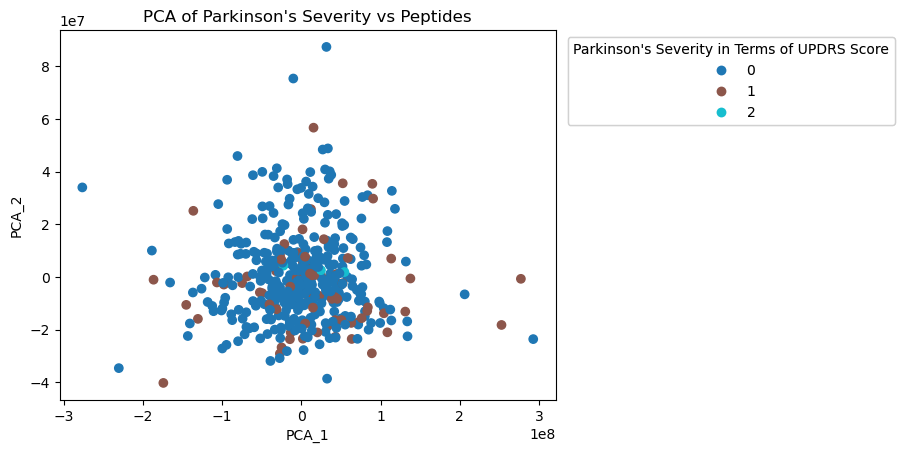

In [57]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=y0, cmap = 'tab10')
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_title("PCA of Parkinson's Severity vs Peptides")
legend3 = ax.legend(*scatter.legend_elements(),bbox_to_anchor=(1.01, 1),
                    loc="upper left", ncol = 1, title="Parkinson's Severity in Terms of UPDRS Score")
ax.add_artist(legend3)

Text(0.5, 1.0, "PCA of Parkinson's Severity vs Peptides")

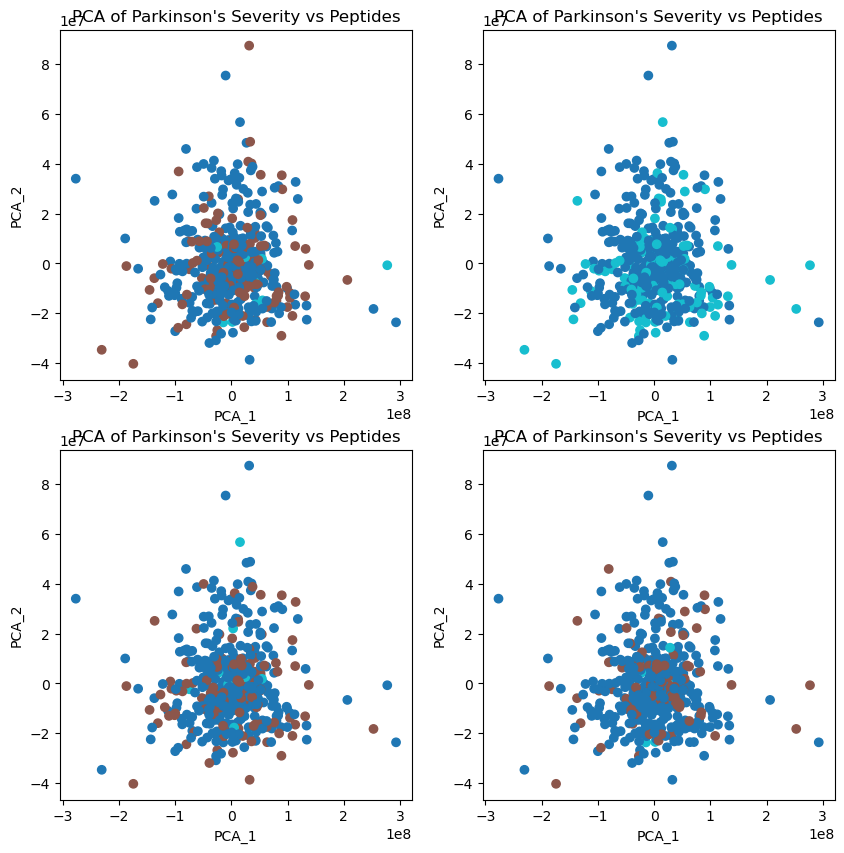

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.scatter(X_pca[:,0], X_pca[:,1], c=y1, cmap = 'tab10')
ax1.set_xlabel('PCA_1')
ax1.set_ylabel('PCA_2')
ax1.set_title("PCA of Parkinson's Severity vs Peptides")
legend4 = ax.legend(*scatter.legend_elements(),bbox_to_anchor=(1.01, 1),
                    loc="upper left", ncol = 1, title="Parkinson's Severity in Terms of UPDRS-1 Score")
ax2.scatter(X_pca[:,0], X_pca[:,1], c=y2, cmap = 'tab10')
ax2.set_xlabel('PCA_1')
ax2.set_ylabel('PCA_2')
ax2.set_title("PCA of Parkinson's Severity vs Peptides")
legend5 = ax.legend(*scatter.legend_elements(),bbox_to_anchor=(1.01, 1),
                    loc="upper left", ncol = 1, title="Parkinson's Severity in Terms of UPDRS-2 Score")
ax3.scatter(X_pca[:,0], X_pca[:,1], c=y3, cmap = 'tab10')
ax3.set_xlabel('PCA_1')
ax3.set_ylabel('PCA_2')
ax3.set_title("PCA of Parkinson's Severity vs Peptides")
legend6 = ax.legend(*scatter.legend_elements(),bbox_to_anchor=(1.01, 1),
                    loc="upper left", ncol = 1, title="Parkinson's Severity in Terms of UPDRS-3 Score")
ax4.scatter(X_pca[:,0], X_pca[:,1], c=y4, cmap = 'tab10')
ax4.set_xlabel('PCA_1')
ax4.set_ylabel('PCA_2')
ax4.set_title("PCA of Parkinson's Severity vs Peptides")


In [59]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [60]:
# Create an empty dictionary to store the models trained for each label.
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

In [61]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df

In [62]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

In [63]:
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")

In [64]:
import tensorflow_decision_forests as tfdf
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [65]:
train_clinical_all = pd.read_csv('train_clinical_data.csv')
proteins = pd.read_csv('train_proteins.csv')
proteins_features = pd.pivot_table(proteins, values='NPX', index='visit_id', columns='UniProt', aggfunc='sum')

train_clinical_all = train_clinical_all.merge(
    proteins_features,
    left_on='visit_id',
    right_index=True,
    how='left'
)

In [66]:
train_clinical_all[proteins_features.columns] = train_clinical_all.groupby('patient_id')[proteins_features.columns].\
                                                                                        fillna(method='ffill')

In [67]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
train_clinical_all

visit_id  patient_id  visit_month  updrs_1_plus_0  updrs_2_plus_0  \
0         55_0          55            0            10.0             6.0   
1         55_3          55            3            10.0             7.0   
2         55_6          55            6             8.0            10.0   
3         55_9          55            9             8.0             9.0   
4        55_12          55           12            10.0            10.0   
...        ...         ...          ...             ...             ...   
2610  65043_48       65043           48             7.0             6.0   
2611  65043_54       65043           54             4.0             8.0   
2612  65043_60       65043           60             6.0             6.0   
2613  65043_72       65043           72             3.0             9.0   
2614  65043_84       65043           84             7.0             9.0   

      updrs_3_plus_0  updrs_4_plus_0 upd23b_clinical_state_on_medication  \
0               15.0             NaN                                 NaN   
1               25.0             NaN                                 NaN   
2               34.0             NaN                                 NaN   
3               30.0             0.0                                  On   
4               41.0             0.0                                  On   
...              ...             ...                                 ...   
2610            13.0             0.0                                 Off   
2611            11.0             1.0                                 Off   
2612            16.0             1.0                                 Off   
2613            14.0             1.0                                 Off   
2614            20.0             3.0                                 Off   

       O00391    O00533  ...  pred_month_plus_12  updrs_1_plus_12  \
0     11254.3  732430.0  ...                12.0             10.0   
1     11254.3  732430.0  ...                 NaN              NaN   
2     13163.6  630465.0  ...                18.0              7.0   
3     13163.6  630465.0  ...                 NaN              NaN   
4     15257.6  815083.0  ...                24.0             16.0   
...       ...       ...  ...                 ...              ...   
2610  10589.6  902434.0  ...                60.0              6.0   
2611  10589.6  902434.0  ...                 NaN              NaN   
2612  10589.6  902434.0  ...                72.0              3.0   
2613  10589.6  902434.0  ...                84.0              7.0   
2614  10589.6  902434.0  ...                 NaN              NaN   

      updrs_2_plus_12  updrs_3_plus_12  updrs_4_plus_12  pred_month_plus_24  \
0                10.0             41.0              0.0                24.0   
1                 NaN              NaN              NaN                 NaN   
2                13.0             38.0              0.0                30.0   
3                 NaN              NaN              NaN                 NaN   
4                 9.0             49.0              0.0                36.0   
...               ...              ...              ...                 ...   
2610              6.0             16.0              1.0                72.0   
2611              NaN              NaN              NaN                 NaN   
2612              9.0             14.0              1.0                84.0   
2613              9.0             20.0              3.0                 NaN   
2614              NaN              NaN              NaN                 NaN   

      updrs_1_plus_24  updrs_2_plus_24  updrs_3_plus_24  updrs_4_plus_24  
0                16.0              9.0             49.0              0.0  
1                 NaN              NaN              NaN              NaN  
2                14.0             13.0             49.0              0.0  
3                 NaN              NaN              NaN              NaN  
4                17.0             18.0 

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from functools import partial

import amp_pd_peptide

from scipy.optimize import minimize
from sklearn.model_selection import GroupKFold

In [69]:
def smape_plus_1(y_true, y_pred):
    y_true_plus_1 = y_true + 1
    y_pred_plus_1 = y_pred + 1
    metric = np.zeros(len(y_true_plus_1))
    
    numerator = np.abs(y_true_plus_1 - y_pred_plus_1)
    denominator = ((np.abs(y_true_plus_1) + np.abs(y_pred_plus_1)) / 2)
    
    mask_not_zeros = (y_true_plus_1 != 0) | (y_pred_plus_1 != 0)
    metric[mask_not_zeros] = numerator[mask_not_zeros] / denominator[mask_not_zeros]
    
    return 100 * np.nanmean(metric)

In [70]:
train_clinical_data = pd.read_csv('train_clinical_data.csv')
train_clinical_data['source'] = 'standard'

supplemental_clinical_data = pd.read_csv('supplemental_clinical_data.csv')
supplemental_clinical_data['source'] = 'supplemental'

train_clinical_all = pd.concat([train_clinical_data, supplemental_clinical_data])

In [71]:
train_clinical_all = train_clinical_all[~train_clinical_all.visit_month.isin([3, 5, 9])]

In [72]:
train_clinical_all['pred_month'] = train_clinical_all['visit_month']

for plus_month in [6, 12, 24]:
    train_shift = train_clinical_all[['patient_id', 'visit_month', 'pred_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].copy()
    train_shift['visit_month'] -= plus_month
    train_shift.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_{plus_month}' for i in range(1, 5)}, inplace=True)
    train_shift.rename(columns={'pred_month': f'pred_month_plus_{plus_month}'}, inplace=True)
    train_clinical_all = train_clinical_all.merge(train_shift, how='left', on=['patient_id', 'visit_month'])

train_clinical_all.rename(columns={f'updrs_{i}': f'updrs_{i}_plus_0' for i in range(1, 5)}, inplace=True)
train_clinical_all.rename(columns={'pred_month': f'pred_month_plus_0'}, inplace=True)
#train_clinical_all

In [73]:
def calculate_predictions(pred_month, trend, target):
    if target == 'updrs_4': pred_month = pred_month.clip(54, None)
    if len(trend) == 2:
        return np.round(trend[0] + pred_month * trend[1]) # linear prediction
    return np.round(trend[0] + pred_month * trend[1] + np.square(pred_month) * trend[2]) # quadratic prediction

def function_to_minimize(x, y_true_array_tr, pred_month_array_tr):    
    metric = smape_plus_1(
        y_true=y_true_array_tr, 
        y_pred=calculate_predictions(
            pred_month=pred_month_array_tr,
            trend=x,
            target=target
        )
    )
    return metric

def model(y_true_array_tr, pred_month_array_tr):
    """Fits a linear or quadratic model to the given data"""
    return list(minimize(
        fun=partial(function_to_minimize,
                    y_true_array_tr=y_true_array_tr,
                    pred_month_array_tr=pred_month_array_tr
                   ),
        # if x0 has two elements, the predictions will be linear
        # if x0 has three elements, the predictions will be quadratic
        x0=[0, 0.0048] if target != 'updrs_3' else [0, 0, 0],
        method='Powell'
    ).x)

In [74]:
all_score_list = []
for i in range(1, 5):
    target = f'updrs_{i}'
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    kf = GroupKFold(n_splits=10)
    score_list = []
    for f, (idx_tr, idx_va) in enumerate(kf.split(train_clinical_all, groups=train_clinical_all.patient_id)):
        y_true_array_tr = train_clinical_all.iloc[idx_tr][columns_with_target].values.ravel()
        pred_month_array_tr = train_clinical_all.iloc[idx_tr][columns_with_pred_month].values.ravel()
        trend = model(y_true_array_tr, pred_month_array_tr)
        y_true_array_va = train_clinical_all.iloc[idx_va][columns_with_target].values.ravel()
        pred_month_array_va = train_clinical_all.iloc[idx_va][columns_with_pred_month].values.ravel()
        score = smape_plus_1(y_true_array_va, calculate_predictions(pred_month_array_va, trend, target))
        print(f"{target} fold {f}: {score:.2f}")
        score_list.append(score)
    score = np.array(score_list).mean()
    print(f"{target}                 {score:.2f}")
    all_score_list.append(score)
    
print(f"cv score                       {np.array(all_score_list).mean():.2f}")
# 55.07 without quadratic term
# 55.02 with quadratic term

updrs_1 fold 0: 57.79
updrs_1 fold 1: 54.68
updrs_1 fold 2: 50.78
updrs_1 fold 3: 54.11
updrs_1 fold 4: 55.21
updrs_1 fold 5: 52.73
updrs_1 fold 6: 57.31
updrs_1 fold 7: 56.29
updrs_1 fold 8: 56.78
updrs_1 fold 9: 55.45
updrs_1                 55.11
updrs_2 fold 0: 69.07
updrs_2 fold 1: 61.44
updrs_2 fold 2: 61.84
updrs_2 fold 3: 65.75
updrs_2 fold 4: 66.44
updrs_2 fold 5: 63.08
updrs_2 fold 6: 66.08
updrs_2 fold 7: 67.37
updrs_2 fold 8: 61.26
updrs_2 fold 9: 67.52
updrs_2                 64.99
updrs_3 fold 0: 61.01
updrs_3 fold 1: 57.33
updrs_3 fold 2: 51.53
updrs_3 fold 3: 67.56
updrs_3 fold 4: 58.92
updrs_3 fold 5: 55.83
updrs_3 fold 6: 62.37
updrs_3 fold 7: 58.54
updrs_3 fold 8: 47.83
updrs_3 fold 9: 59.72
updrs_3                 58.06
updrs_4 fold 0: 48.68
updrs_4 fold 1: 43.01
updrs_4 fold 2: 44.41
updrs_4 fold 3: 39.82
updrs_4 fold 4: 38.65
updrs_4 fold 5: 47.35
updrs_4 fold 6: 36.22
updrs_4 fold 7: 34.35
updrs_4 fold 8: 43.10
updrs_4 fold 9: 43.71
updrs_4                 41.93


In [75]:
target_to_trend = {}
for i in range(1, 5):
    target = f'updrs_{i}'
    columns_with_target = [f'{target}_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    columns_with_pred_month = [f'pred_month_plus_{plus_month}' for plus_month in [0, 6, 12, 24]]
    y_true_array = train_clinical_all[columns_with_target].values.ravel()
    pred_month_array = train_clinical_all[columns_with_pred_month].values.ravel()
    trend = model(y_true_array, pred_month_array)
    target_to_trend[target] = trend
display(target_to_trend)

{'updrs_1': [5.394793062665313, 0.027091086167821344],
 'updrs_2': [5.469498130092747, 0.02824188329658148],
 'updrs_3': [21.450374496989554, 0.035651592857152345, 0.0010867699338717358],
 'updrs_4': [-4.434453480103724, 0.07531448585334258]}

In [76]:
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files

# The API will deliver four dataframes in this specific order:
for test_clinical_data, test_peptides, test_proteins, sample_submission in iter_test:
    sample_submission['patient_id'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[0]))
    sample_submission['visit_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[1]))
    sample_submission['target_name'] = sample_submission['prediction_id'].map(lambda x: 'updrs_' + x.split('_')[3])
    sample_submission['plus_month'] = sample_submission['prediction_id'].map(lambda x: int(x.split('_')[5]))
    sample_submission['pred_month'] = sample_submission['visit_month'] + sample_submission['plus_month']
    
    for i in range(1, 5):
        target = f'updrs_{i}'
        mask_target = sample_submission['target_name'] == target
        sample_submission.loc[mask_target, 'rating'] = calculate_predictions(
            pred_month=sample_submission.loc[mask_target, 'pred_month'],
            trend=target_to_trend[target],
            target=target
        )
        
    # call env.predict for every iteration
    env.predict(sample_submission[['prediction_id', 'rating']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
